In [1]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
decodedCaptionPath = "./imageCaptioning/outputs/decodedTestCaptions.json"
referencePath = "./imageCaptioning/rsicdDataset/testAnnotations.json"
imageDirectory = "./imageCaptioning/rsicdDataset/images/test"

In [7]:
with open(decodedCaptionPath, "r") as file:
    genData = json.load(file)
genFiles = [os.path.basename(file) for file in genData["imageFiles"]]
genCaptions = genData["captions"]

print(f"{genFiles[0]} : {genCaptions[0]}")

00640.jpg : the playground is surrounded by a football field and a football field


In [8]:
with open(referencePath, "r") as file:
    referenceData = json.load(file)
referenceMap = {
    item["filename"] : item["captions"] for item in referenceData
}

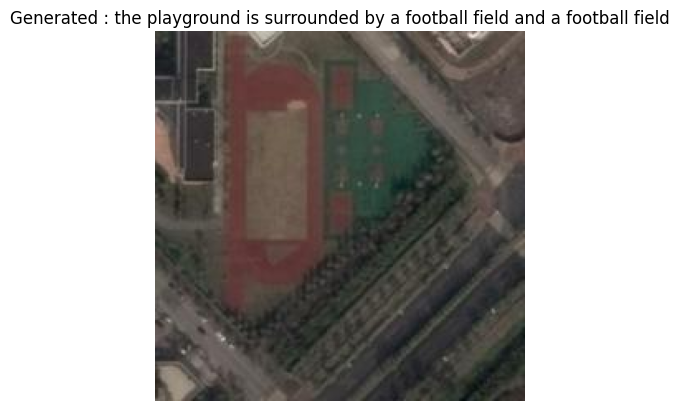

References
    - the small playground is at the triangular area formed by buildings and streets
    - a playground is between buildings and green trees
    - a playground next to two intersections lies between two parallel roads
    - a playground with two basketball fields next to it is between two roads
    - a playground next to two crossroads is between two parallel roads .


In [9]:
# Display Function
def showImageWithCaptions(index):
    filename = genFiles[index]
    imagePath = os.path.join(imageDirectory, filename)
    image = Image.open(imagePath)
    genCaption = genCaptions[index]
    references = referenceMap.get(filename, [])

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Generated : {genCaption}")
    plt.show()
    print("References")
    for reference in references:
        print(f"    - {reference}")


showImageWithCaptions(0)

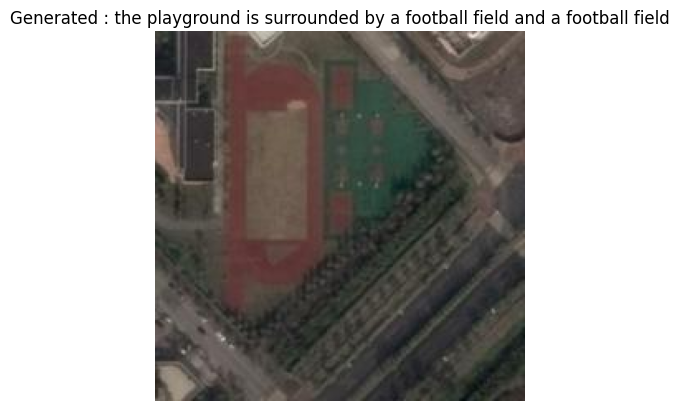

References
    - the small playground is at the triangular area formed by buildings and streets
    - a playground is between buildings and green trees
    - a playground next to two intersections lies between two parallel roads
    - a playground with two basketball fields next to it is between two roads
    - a playground next to two crossroads is between two parallel roads .


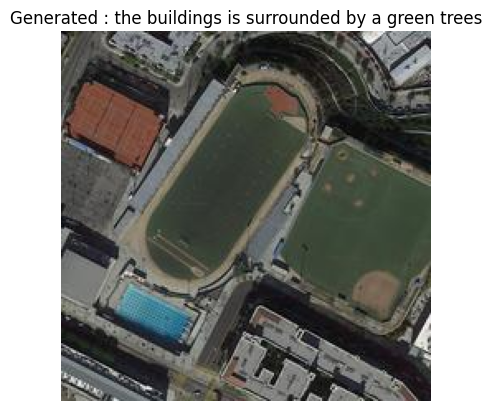

References
    - tennis courts, basketball courts, football field, baseball field and swimming pool are the parts of this park, surrounded by a curved road
    - several large buildings are around a playground and a baseball field
    - a playground and a baseball pitch are surrounded by many buildings
    - a playground with a baseball field next to it is surrounded by many buildings
    - a playground and a baseball field are surrounded by many buildings .


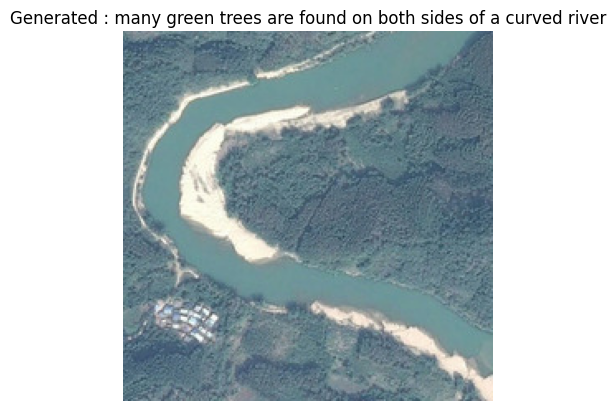

References
    - in the forest there is a v-shaped river with an area of buildings on the shore
    - among forest  there is a v shaped river with a zone of buildings on the bank
    - a u shaped river is between two forests
    - several houses are located in the forest nearby this curved green river
    - many green trees and several building in a cluster are in two sides of a curved green river .


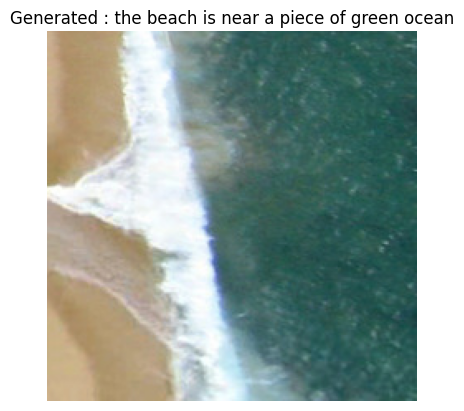

References
    - the beach near the ocean is wet with water
    - the ocean in front of the beach is broad
    - a white stripe lies between the sea and the beach
    - a white tape lies between the sea and the beach
    - the beach near the ocean is wet with water .


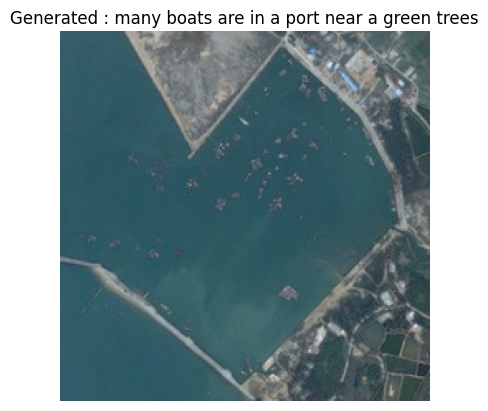

References
    - around the port is a large lawn area
    - next to the road is a densely populated area
    - next to the road is a densely populated area
    - around the port is a large grass area
    - around the harbor is a large area of lawn .


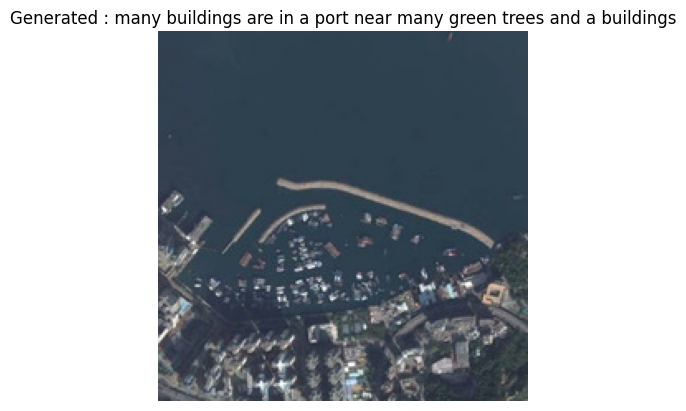

References
    - With three sea walls, the port is located near a road and some buildings
    - Owning three sea walls the port is located near a road and some buildings
    - owning three seawalls  the port is located near a road and some buildings
    - several buildings stands on the bank of this crammed deep blue port
    - many boats are in a port near many buildings and some green trees .


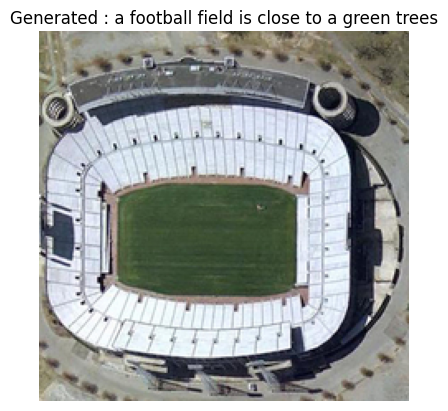

References
    - a row of trees were planted around the stadium
    - there is a football stadium in the gym
    - It's a stadium that hasn't been built
    - this is a stadium which hasn't been built
    - a row of trees were planted around the stadium .


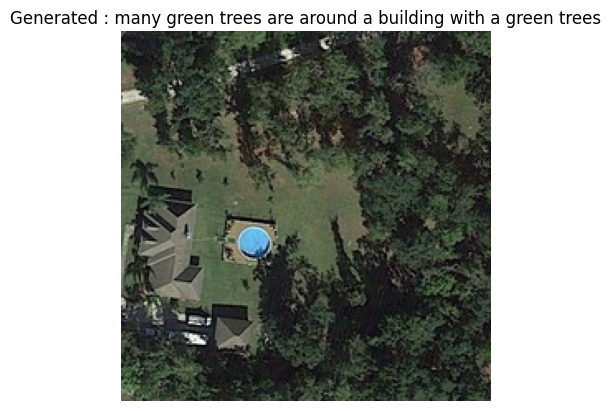

References
    - In front of the house there is a blue circular bath
    - In front of the house there is a blue circular swimming
    - in front of the house there is a blue circular swimming
    - there is a round swimming pool besided this house with plenty trees standing around
    - a gray building with a pond is surrounded by many green trees .


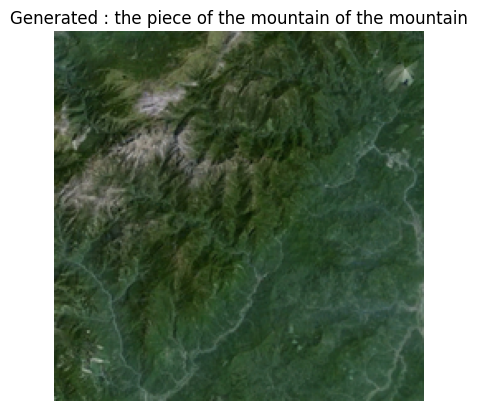

References
    - roads and rivers can be seen in the valleys
    - roads and rivers can be seen in the valleys
    - roads and rivers can be seen in the valleys
    - it is a beautiful green mountain range with several footpaths traverses through
    - it is a piece of irregular green mountains .


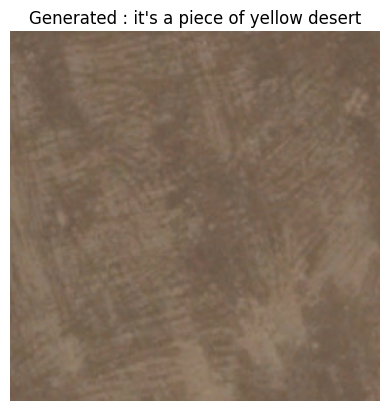

References
    - The vast earth is a bare earth
    - no plants were planted on the bare earth
    - no plants were planted on the bare land
    - The vast land is a bare land
    - the vast land is a bare land .


In [10]:
for i in range(10):
    showImageWithCaptions(i)